<a href="https://colab.research.google.com/github/rafalopes74/EnergyConsumptionAI/blob/main/EnergyConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
!pip install holidays --upgrade

In [84]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import holidays
plt.style.use('ggplot')

In [85]:
!wget --no-clobber https://raw.githubusercontent.com/rafalopes74/EnergyConsumptionAI/main/DAYTON_hourly.csv


File ‘DAYTON_hourly.csv’ already there; not retrieving.



In [86]:
data = pd.read_csv("/content/DAYTON_hourly.csv", header = 'infer', parse_dates = True)
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index("Datetime")

In [87]:
data.shape

(121275, 1)

In [88]:
data.tail(5)

,DAYTON_MW
Datetime,
2018-01-01 20:00:00,2732.0
2018-01-01 21:00:00,2724.0
2018-01-01 22:00:00,2664.0
2018-01-01 23:00:00,2614.0
2018-01-02 00:00:00,2552.0


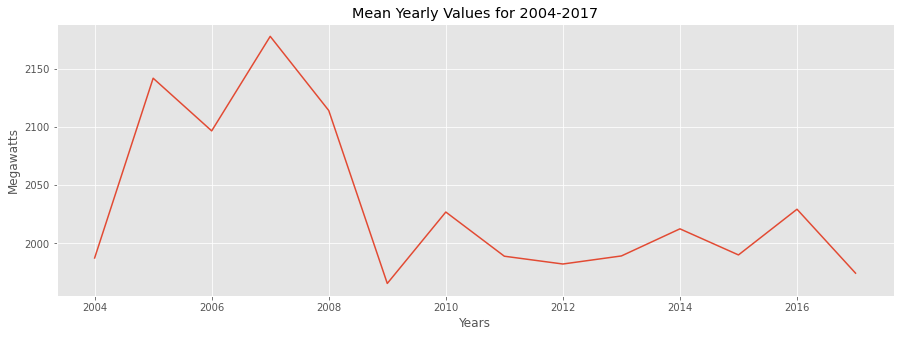

In [89]:
# YEARLY CONSUMPTIONS

mean_yearly_consumptions = []
years = []

for i in range(2004, 2018):
  mean_yearly_consumptions.append(data[data.index.year == i].mean())
  years.append(i)

plt.figure(figsize = (15, 5))
plt.plot(years, mean_yearly_consumptions)

plt.title("Mean Yearly Values for 2004-2017")
plt.xlabel("Years")
plt.ylabel("Megawatts")

plt.show()

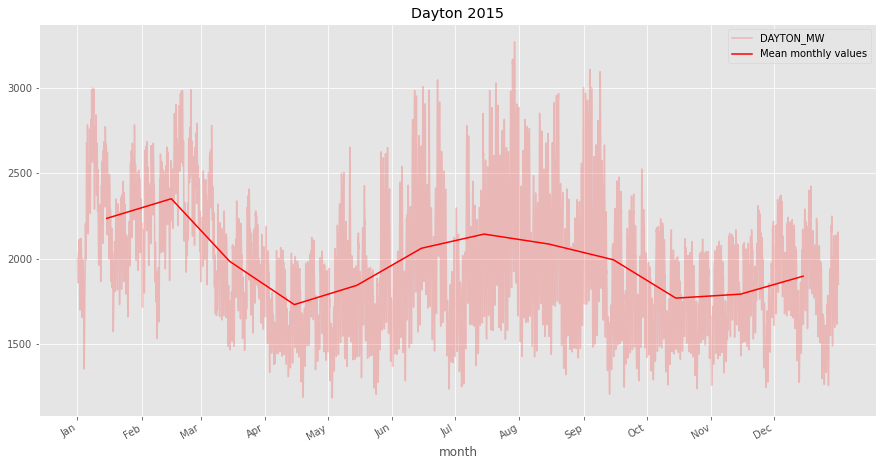

In [90]:
year_2015 = data[data.index.year == 2015]

month_mean_values = []
months = []
xticks = []
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in (range(1,13)):
    month_mean_values.append(year_2015[(year_2015.index.month == i)]['DAYTON_MW'].mean())
    months.append(datetime.datetime(2015, i, 15))
    xticks.append(datetime.datetime(2015, i, 1)) 

month = pd.DataFrame({'Mean monthly values': month_mean_values, 'month':months })
month = month.set_index('month')

base=year_2015.plot(color='red',alpha=0.20, figsize = (15, 8), title = 'Dayton 2015')
month.plot(color='red', alpha=1.0, ax=base)
plt.xticks(xticks, month_names)

plt.show()

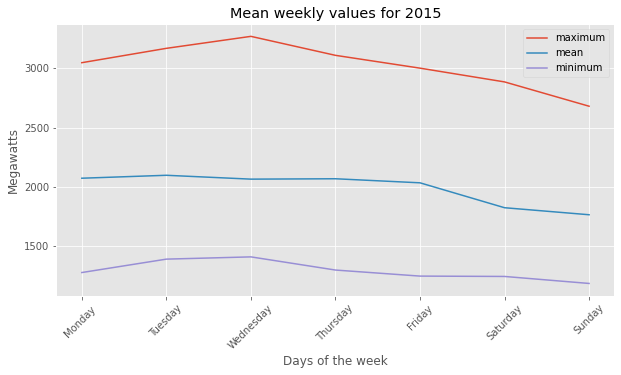

In [91]:
# VALUES BY WEEKDAY

mean_weekday = []
max_weekday = []
min_weekday = []
weekdays = ['Monday ', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i in range(0, 7):
  mean_weekday.append(data[(data.index.year == 2015) & (data.index.weekday == i)].mean())
  max_weekday.append( data[(data.index.year == 2015) & (data.index.weekday == i)].max())
  min_weekday.append( data[(data.index.year == 2015) & (data.index.weekday == i)].min())

plt.figure(figsize = (10, 5))
plt.plot(weekdays, max_weekday, weekdays, mean_weekday, weekdays, min_weekday)

plt.title('Mean weekly values for 2015')
plt.xlabel('Days of the week')
plt.ylabel('Megawatts')
plt.xticks(weekdays, rotation = 45)
plt.legend(['maximum', 'mean', 'minimum'])

plt.show()

In [101]:
weekday = pd.DataFrame({'DAYTON_MW' : []})
weekend = []
public_holiday = []

ohio_holidays = holidays.country_holidays('US', subdiv='OH', years=2015)

for holiday in ohio_holidays:
  pd.concat( [weekday, data[(data.index.year == 2015) & (data.index.weekday < 5) & (data.index.date != holiday)]] )
  weekend.append(data[(data.index.year == 2015) & (5 <= data.index.weekday) & (data.index.weekday == 6)])
  public_holiday.append(data[(data.index.year == 2015) & (5 <= data.index.weekday) & (data.index.date == holiday)])

print(data)
#plt.boxplot(list(weekday))

                     DAYTON_MW
Datetime                      
2004-12-31 01:00:00     1596.0
2004-12-31 02:00:00     1517.0
2004-12-31 03:00:00     1486.0
2004-12-31 04:00:00     1469.0
2004-12-31 05:00:00     1472.0
...                        ...
2018-01-01 20:00:00     2732.0
2018-01-01 21:00:00     2724.0
2018-01-01 22:00:00     2664.0
2018-01-01 23:00:00     2614.0
2018-01-02 00:00:00     2552.0

[121275 rows x 1 columns]


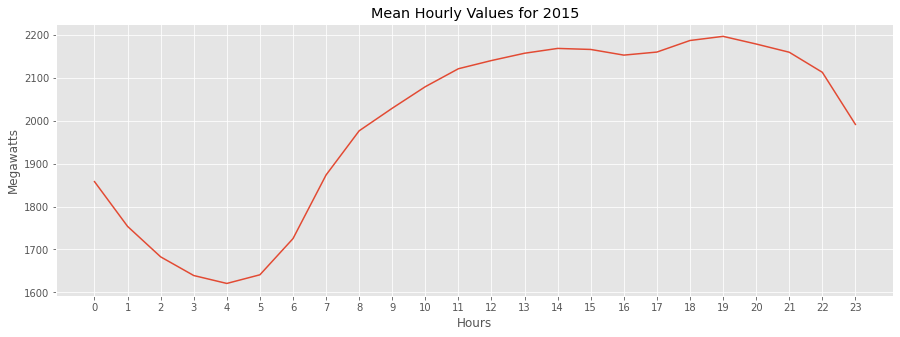

In [93]:
#           MEAN HOURLY VALUES

mean_hourly_values = []
hours = [x for x in range(0, 24)]

for i in range(0, 24):
  mean_hourly_values.append(data[(data.index.year == 2015) & (data.index.hour == i)].mean())

plt.figure(figsize = (15, 5))
plt.plot(hours, mean_hourly_values)

plt.title("Mean Hourly Values for 2015")
plt.xlabel("Hours")
plt.ylabel("Megawatts")
plt.xticks(hours)

plt.show()